## MacOS version

### connect with your mircobit device

In [1]:
#importing packages
import serial
import time
import pandas as pd
import numpy as np

ser = serial.Serial()
ser=serial.Serial("/dev/cu.usbmodem144102",115200)
# type "ls /dev/cu.*" in terminal to find the serial number for MacOS device, this number may be different for each time

### generate random color with CV2

In [2]:
import random
import numpy as np
import cv2

# Function to generate random color
def generate_random_color():
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)
    return blue, green, red  # OpenCV uses BGR color format

# Function to calculate the loss between two colors
def calculate_loss(color1, color2):
    return np.sqrt((color1[0] - color2[0]) ** 2 + (color1[1] - color2[1]) ** 2 + (color1[2] - color2[2]) ** 2)

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (0, 0, 255)  # Red color (BGR format)

# Create an empty list to store the loss values
loss_values = []

# Main loop
num_iterations = 0
max_iterations = 10  # Set the desired number of iterations

while num_iterations < max_iterations:
    # Generate a new random color
    current_color = generate_random_color()

    # Calculate the loss between the goal color and the current color
    loss = calculate_loss(goal_color, current_color)

    # Add the loss value to the list
    loss_values.append(loss)

    # Update the live image with the current color
    image[:, :] = current_color

    # Add text information to the image
    text = f"Iteration: {num_iterations + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = width // (max_iterations + 1)
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), goal_color, -1)

    # Add text for the loss
    loss_text = f"Loss: {loss:.2f}"
    cv2.putText(image, loss_text, (10, height - 10), font, font_scale, font_color, 2)

    # Draw the graph of loss values
    if len(loss_values) > 1:
        for i in range(1, len(loss_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(loss_values[i - 1] * (height - 60) / max(loss_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(loss_values[i] * (height - 60) / max(loss_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Display the image
    cv2.imshow("Live Image", image)
    cv2.waitKey(1000)  # Adjust the wait time (in milliseconds) as needed

    # Increment the iteration counter
    num_iterations += 1

# Close the window after the desired number of iterations
cv2.destroyAllWindows()


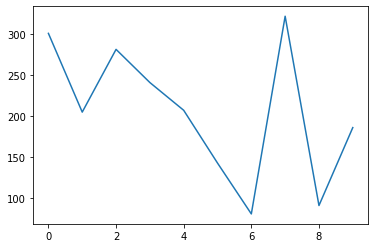

In [3]:
import matplotlib.pyplot as plt
plt.plot(loss_values)

### use bayesian to reach the goal color

(Characterisation) Measure RGB sample:
{'R': 117, 'G': 71, 'B': 61, 'outcome': 237.41524803600967, 'time': 1689539005.017233}
(Characterisation) Measure RGB sample:
{'R': 122, 'G': 69, 'B': 59, 'outcome': 240.95850265139018, 'time': 1689539005.975181}
(Characterisation) Measure RGB sample:
{'R': 68, 'G': 109, 'B': 65, 'outcome': 229.35779908256882, 'time': 1689539006.944224}
(Characterisation) Measure RGB sample:
{'R': 135, 'G': 64, 'B': 56, 'outcome': 248.84131489766727, 'time': 1689539007.918304}
(Characterisation) Measure RGB sample:
{'R': 187, 'G': 34, 'B': 38, 'outcome': 288.46836914989484, 'time': 1689539008.887062}
(Characterisation) Measure RGB sample:
{'R': 186, 'G': 37, 'B': 37, 'outcome': 288.9446313742479, 'time': 1689539010.155988}
(Characterisation) Measure RGB sample:
{'R': 179, 'G': 43, 'B': 38, 'outcome': 284.568093784247, 'time': 1689539011.450079}
(Characterisation) Measure RGB sample:
{'R': 186, 'G': 37, 'B': 32, 'outcome': 292.7353753819309, 'time': 1689539012.7279

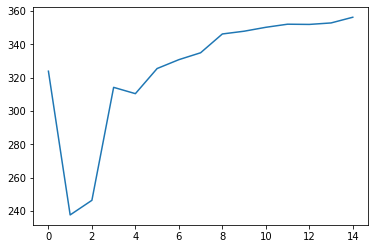

In [7]:
import serial
import time
import numpy as np
import cv2
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

ser = serial.Serial("/dev/cu.usbmodem144102", 115200)

# Define the optimization goal
goal_color = (0, 0, 255)  # Red color (BGR format)

# Initialize CV2 window for live image display
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)

max_iterations = 15  # Set the desired number of iterations

serial_line_tested = False
def test_serial_line():
    ser.write(b",")
    serial_data = str(ser.readline().decode('utf8'))
    serial_data = str(ser.readline().decode('utf8'))
    serial_data = str(ser.readline().decode('utf8'))
    # do nothing with it
    global serial_line_tested
    serial_line_tested = True

def calculate_loss(color1, color2):
    return np.sqrt(
        (color1[0] - color2["R"]) ** 2
        + (color1[1] - color2["G"]) ** 2
        + (color1[2] - color2["B"]) ** 2
    )

def measure_outcome():
    if not serial_line_tested:
        test_serial_line()
    time.sleep(0.4)
    print('(Characterisation) Measure RGB sample:')
    ser.write(b",")
    serial_data = str(ser.readline().decode('utf-8'))
    new_sample = {}
    while True:
        color, val = serial_data.split(":")
        new_sample[str(color)] = int(val)
        if color == "B":
            break
        else:
            serial_data = str(ser.readline().decode('utf-8'))

    # Make sure the keys "R", "G", and "B" exist in the new_sample dictionary
    for color_key in ["R", "G", "B"]:
        if color_key not in new_sample:
            new_sample[color_key] = 0

    new_sample["outcome"] = calculate_loss(goal_color, new_sample)
    new_sample["time"] = time.time()

    print(new_sample)
    return new_sample

def objective_function(R, G, B):
    # Simulate the outcome based on the RGB values
    outcome = calculate_loss(goal_color, {'R': R, 'G': G, 'B': B})
    return outcome

# Define the utility function (Expected Improvement)
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

loss_values = []

if __name__ == "__main__":
    # Define the search space bounds
    pbounds = {'R': (0, 255), 'G': (0, 255), 'B': (0, 255)}

    # Define the Bayesian optimization function
    optimizer = BayesianOptimization(
        f=objective_function,
        pbounds=pbounds,
        random_state=1,
        verbose=2
    )

    for iteration in range(max_iterations):
        # Measure the outcome from the micro:bit
        new_sample = measure_outcome()

        # Update the optimizer with the new sample
        optimizer.register(params={'R': new_sample['R'], 'G': new_sample['G'], 'B': new_sample['B']}, target=new_sample['outcome'])

        # Optimize the acquisition function to get the next sample
        next_sample = optimizer.suggest(utility_function=utility)

        # Update the live image with the current color
        image[:, :] = [next_sample['B'], next_sample['G'], next_sample['R']]

        # Add text information to the image
        text = f"Iteration: {iteration + 1}"
        cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

        # Add text for the loss
        loss_text = f"Loss: {new_sample['outcome']:.2f}"
        cv2.putText(image, loss_text, (10, height - 10), font, font_scale, font_color, 2)
        # Plot a subplot for the goal color
        subplot_x = width // (max_iterations + 1)
        subplot_width = width // (max_iterations + 1)
        cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), goal_color, -1)
        
        # Calculate the loss between the goal color and the current color
        loss = calculate_loss(goal_color, {'R': next_sample['R'], 'G': next_sample['G'], 'B': next_sample['B']})
        # Add the loss value to the list
        loss_values.append(loss)
        
        # Display the updated image
        cv2.imshow("Live Image", image)
        cv2.waitKey(500)

        # Other optimization steps (omitted for clarity)

    # Save the final image
    cv2.imwrite("final_image.png", image)

    # Close the CV2 window
    cv2.destroyAllWindows()

plt.plot(loss_values)
